In [1]:
import pandas as pd
import seaborn as sns
import re
import numpy as np
import random
import string
import matplotlib.pyplot as plt
import json

import nltk
from nltk.tokenize import word_tokenize

import spacy

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from sklearn.metrics import precision_recall_curve
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.base import TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.base import BaseEstimator, TransformerMixin


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

from yellowbrick.classifier import ROCAUC


import gensim.downloader as api

import warnings
warnings.filterwarnings("ignore")

nlp = spacy.load('en_core_web_sm')
nltk.download('punkt')
nltk.download('gutenberg')

[nltk_data] Downloading package punkt to /Users/umer/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package gutenberg to /Users/umer/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

# Read Data

In [2]:
all_books_names = list(map(lambda x: x.replace('.txt', ''), nltk.corpus.gutenberg.fileids()))
all_books_names

['austen-emma',
 'austen-persuasion',
 'austen-sense',
 'bible-kjv',
 'blake-poems',
 'bryant-stories',
 'burgess-busterbrown',
 'carroll-alice',
 'chesterton-ball',
 'chesterton-brown',
 'chesterton-thursday',
 'edgeworth-parents',
 'melville-moby_dick',
 'milton-paradise',
 'shakespeare-caesar',
 'shakespeare-hamlet',
 'shakespeare-macbeth',
 'whitman-leaves']

## choose books

In [3]:
all_books_names = ["carroll-alice", "chesterton-ball", "edgeworth-parents", "bryant-stories", "melville-moby_dick"]

# Helper functions

In [158]:
def process_one_book(book_corpus, partions_num=None, clean_it=True, words_num=100, random_partions=False):
    '''
    Process one book by split it to partions, where each partition contains $words_num of words,
    then return $partions_num of different partions.
    args:
      - book_corpus     (str)  -> list contains the book's corpus as words.
      - partions_num    (int)  -> number of partitions that will be returned, 
                                  note that if no enough words exist,
                                  it will return the max possible number of partitions.
      - clean_it        (bool) -> if True, will apply clean first.
      - words_num       (int)  -> number of words per partion.
      - random_partions (bool) -> get $partions_num of partitions randomly or from the whole partitions,
                                  of Fale, it will return them sequentially.

    output:
      - out (list) -> list of partions as list of strings.
    '''

    if clean_it:
        book_corpus = clean( book_corpus ).split(' ')


    num_of_possible_partions = len(book_corpus) // words_num
    
    if partions_num:
        max_num_of_partions = min(partions_num, num_of_possible_partions)
    else:
        max_num_of_partions = num_of_possible_partions
    
    partions = [ ' '.join(book_corpus[ i*words_num : i*words_num + words_num]) for i in range(num_of_possible_partions)]

    if random_partions:
        random.shuffle(partions)
                
    return partions[:max_num_of_partions]



def clean(txt):
    '''
    Elminate any non word character from the input text, and remove any additionl spaces.
    
    Args:
      - txt (string) -> the unclean text.
    '''
    txt = re.sub(r'\W', ' ', txt)
    txt = re.sub(r' \w ', ' ', txt)
    txt = re.sub(r' +', ' ', txt)
    return txt.strip().lower()


def processText(text):   
    doc = nlp(text)
    lemma_list = [str(token.lemma_) for token in doc]
    
    #Filter the stopword
    filtered_sentence =[] 
    for word in lemma_list:
        lexeme = nlp.vocab[word]
        if lexeme.is_stop == False:
            filtered_sentence.append(word) 
    
    #Remove punctuation
    punctuations = set(["?", ":", "!", ".", ",", ";"])
    filtered_sentence = [word for word in filtered_sentence if word not in punctuations]

    return ' '.join(filtered_sentence).strip()



def plotRegions(model, X, ax=None):
    """
    Plot meshgrid for given @model to differentiate between each class region.

    Args:
        @model (obj)        : The trained model.
        @X     (np matrix)  : The dataset matrix.
        @ax    (matplot ax) : This is the axis of fig, in case of subplot specification.
    """
    if ax == None:
        fig, ax = plt.subplots()
        
    margin = .4
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    XX, YY = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    z = model.predict(np.c_[XX.ravel(), YY.ravel()])
    ZZ = z.reshape(XX.shape)
    ax.contourf(XX, YY, ZZ, alpha=0.2)
    
    
def plotData(X, Y, labels, ax=None, title=None, colors=None, markers=None):
    """
    Plot Dataset as scatter plot.

    Args:
        @X       (np matrix)  : The dataset matrix.
        @Y       (np array)   : Has the truth values for each instance.
        @labels  (list)       : List of the real name of each class.
        @ax      (matplot ax) : This is the axis of fig, in case of subplot specification.
        @title   (str)        : The figuer's title.
        @colors  (list)       : List of custmized colors.
        @markers (list)       : List of custmized markers.
    """
        
    if ax == None: fig, ax = plt.subplots()
    
    if not colors:
        colors = list(mcolors.TABLEAU_COLORS.values())[:len(labels)]
    if not markers:
        markers = list(Line2D.markers.keys())
    
    for index, label in enumerate(labels):
        ax.scatter(
            x=X[Y == index][:,0],
            y=X[Y == index][:,1],
            c=colors[index],
            marker=markers[index],
            label=labels[index]
        )
    
    if title == None: title = "Dataset with {n} classes".format(n=int(len(labels)))
    ax.set_title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12),
          fancybox=True, shadow=True, ncol=5)
#     plt.legend()
    

def getAccuracy(y, y_pred):
    """
    Get the accuracy of given @y and @y_pred.

    Args:
        @y      (list)   : Has the truth values for each instance.
        @y_pred (list)   : Has the predicted values for each instance.
    
    Returns:
        The calculated accuracy.
    """
    acc = accuracy_score(y, y_pred)
    print(f"acc :: {acc}")
    return acc
    

def getF1_cross_val(model, x, y, cv):
    """
    Calculate the F1-score after applying Cross-Validation on @model using the given @x and @y.
    
    Args:
        @model  (obj)       : The trained model.
        @x      (np matrix) : The dataset matrix.
        @y      (list)      : Has the truth values for each instance.
        @cv     (int)       : Number of K-folds.
    
    Returns:
        the calculated F1-score.
    """
    scores = cross_val_score(model, x, y, cv=cv, scoring='f1_macro')
    print("Cross-Validation :: %0.2f avg-f1-score" % (scores.mean()))
    return scores


def getAccReport(y, y_pred, labels):
    """
    Calculate the F1-score, Precision and recall for each class.    
    
    Args:
        @y      (list) : Has the truth values for each instance.
        @y_pred (list) : Has the predicted values for each instance.
        @labels (list) : List of the real name of each class.
    """
    print(classification_report(y, y_pred, target_names=labels))
    
    
    
def plotConfMat(y, y_pred, labels, errorAnalysis=False):
    """
    Plot the Confusion Matrix and Error-Analysis conf-matx debend on the value of @errorAnalysis.    
    
    Args:
        @y      (list)        : Has the truth values for each instance.
        @y_pred (list)        : Has the predicted values for each instance.
        @labels (list)        : List of the real name of each class.
        @errorAnalysis (bool) : To swap between ErrorAnalysis and regular conf-matx.
    """
    
    conf_mx = confusion_matrix(y, y_pred)
    plt.figure(figsize=(7, 4))
    if errorAnalysis:
        print('Error Analysis')
        row_sums = conf_mx.sum(axis=1, keepdims=True)
        norm_confx_mx = conf_mx / row_sums
        # replace all TP with zeros
        np.fill_diagonal(norm_confx_mx, 0)

        ax = sns.heatmap(norm_confx_mx, annot=True, cmap='Blues')
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=45)
        plt.show()
    else:
        ax = sns.heatmap(conf_mx, annot=True, cmap='Blues', fmt='d')
        ax.xaxis.set_ticklabels(labels)
        ax.yaxis.set_ticklabels(labels)
        ax.tick_params(axis='x', rotation=45)
        ax.tick_params(axis='y', rotation=45)
        plt.show()
            
    
def plotLearningCurve(model, ax=None):
    """
    Plot learning Curve for the given @model.

    Args:
        @model (obj)        : The trained model.
        @ax    (matplot ax) : This is the axis of fig, in case of subplot specification.
    """
    losses = model.loss_curve_
    
    if ax == None:
        fig, ax = plt.subplots()
            
    ax.plot(range(1, len(losses)+1), losses)
    # add axis labels to plot
    ax.set_title('Learning Curve')
    ax.set_xlabel('#-epochs')
    ax.set_ylabel('loss')

    
def getModelReport(model, x, y, labels):
    """
    get Full report for the given @model.

    Args:
        @model  (obj)       : The trained model.
        @x      (np matrix) : The dataset matrix.
        @y      (list)      : Has the truth values for each instance.
        @labels (list)      : List of the real name of each class.
    """
    
    print("model : ")
    
    y_pred = model.predict(x)
    # get the accuracy of trained model
    getAccuracy(y, y_pred)
        
    getAccReport(y, y_pred, labels)
        
    plotConfMat(y, y_pred, labels)
    
    plotConfMat(y, y_pred, labels, errorAnalysis=True)
      
#     plt.figure(figsize=(10, 8))
#     fig, ax = plt.subplots()
#     plotRegions(model, x, ax=ax)
#     plotData(x, y, labels, ax=ax)
    
    #plot learning curve if the model has losses_
    try:
        plotLearningCurve(model)
    except:
        pass
    
    
def plotProbabilityDis(y_probs, y, labels, ax=None):
    """
    Plot Probability Distribution for each class on same figure to illustrate the overlapping.

    Args:
        @y       (list)        : Has the truth values for each instance.
        @y_probs (list)        : Has the predicted probabilities for each instance.
        @labels  (list)        : List of the real name of each class.
        @ax      (matplot ax)  : This is the axis of fig, in case of subplot specification.
    """
    if ax == None:
        fig, ax = plt.subplots()
        
    colors = list(mcolors.TABLEAU_COLORS.values())[:len(labels)]

    for indx, label in enumerate(labels):
        ax.hist(y_probs[y == indx], 20, density = True, 
            histtype ='bar',
            color = colors[indx],
            label = label)
        
    ax.set_title(f'{labels[0]} vs {labels[1]}')
    ax.legend([f"Class 0: {labels[0]}", f"Class 1: {labels[1]}"])
    ax.set_xlabel(f"P(x = {labels[1]})")
    
    
def plotROC(y_probs, y, labels, model_name, ax=None):
    """
    Plot ROC curve and get AUC.

    Args:
        @y          (list)        : Has the truth values for each instance.
        @y_probs    (list)        : Has the predicted probabilities for each instance.
        @labels     (list)        : List of the real name of each class.
        @model_name (str)         : The label of figure.
        @ax         (matplot ax)  : This is the axis of fig, in case of subplot specification.
    """
    if ax == None:
        fig, ax = plt.subplots()
            
    ns_probs = np.zeros(len(y))
    ns_fpr, ns_tpr, _ = roc_curve(y, ns_probs)
    ax.plot(ns_fpr, ns_tpr, linestyle='--')
    
    fpr, tpr, _ = roc_curve(y, y_probs)
    ax.plot(fpr, tpr, marker='.', label=model_name)
    
    # get AUC
    auc = round(roc_auc_score(y, y_probs), 2)
    
    ax.set_title(f"ROC Curve with AUC :: {auc}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    
    
def plotPercesionRecall(y, y_probs, ax=None):
    """
    Plot the percesion and Recall plot.  
    
    Args:
        @y       (list)       : Has the truth values for each instance.
        @y_probs (list)       : Has the predicted probabilities for each instance.
        @ax      (matplot ax) : This is the axis of fig, in case of subplot specification.
    """
    if ax == None:
        fig, ax = plt.subplots()
            
    #calculate precision and recall
    precision, recall, thresholds = precision_recall_curve(y, y_probs)
    ax.plot(recall, precision)
    #add axis labels to plot
    ax.set_title('Precision-Recall Curve')
    ax.set_ylabel('Precision')
    ax.set_xlabel('Recall')
    
    
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        try:
            return X.todense()
        except:
            return X
    
    
class CustomVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, model=None):
        self.model = model
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array(list(map(lambda x: self._vectorizeSentence(x) , X)))
        
    def _vectorizeSentence(self, sent):
        vect = self.model.vectors_for_all(word_tokenize(sent)).vectors
        if vect.shape[0] == 0: return np.zeros(vect.shape[1])    
        return np.sum(np.array(vect), axis=0)
    
    
# TSNE(perplexity=40, n_components=2, init='pca')
def plotPragraphSpace(X, Y, VecAlgo, custom=False):
    dim_red_algos = {
                  "LDA" : LinearDiscriminantAnalysis(n_components=2),
                  "PCA" : PCA(n_components=2),
                  "T-SNE" : TSNE(n_components=2, learning_rate='auto', init='random', random_state=43),
                  "UMAP" : umap.UMAP(),
                }
    
    if custom:
        VecAlgo = CustomVectorizer(model=VecAlgo)
    
    pip = Pipeline([
            ('vect', VecAlgo),
            ('to_dense', DenseTransformer()),
        ])
    pip.fit(X, Y)
    new_x = pip.transform(X)

    plt.figure(figsize = (25, 15)) 
    for i, key in enumerate(dim_red_algos.keys()):

        dim_algo = dim_red_algos[key]

        ax = plt.subplot(2, 2, i+1)

        try:
            new_x_redu = dim_algo.fit_transform(new_x, y_train)
        except:
            new_x_redu = dim_algo.fit_transform(new_x)

        colors = list(mcolors.TABLEAU_COLORS.values())[:len(set(y_train))]
        for i, clas in enumerate(set(y_train)):
            x = new_x_redu[y_train == clas][:, 0]
            y = new_x_redu[y_train == clas][:, 1]
            ax.scatter(x, y, c=colors[i], label=clas)
        ax.set_title(key)
        plt.legend()

#### All those books are fiction books, so they have the same genres and are semantically the same

In [5]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


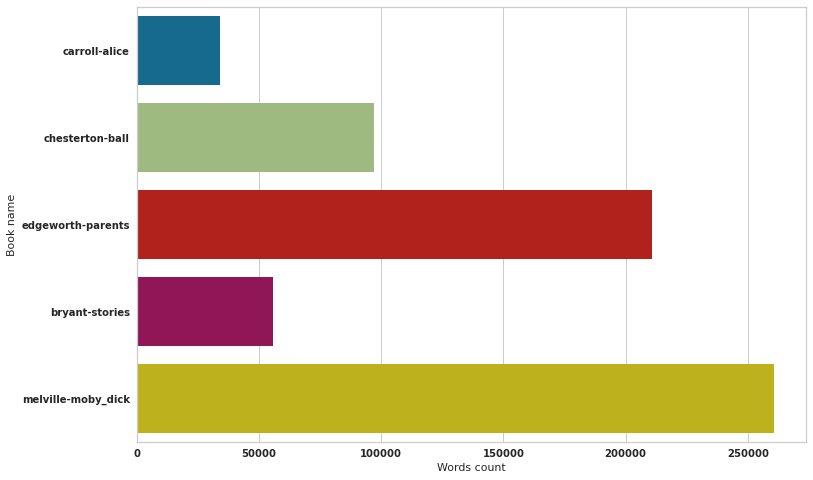

In [6]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y=all_books_names, x=[ len(nltk.corpus.gutenberg.words(f'{book_name}.txt')) for book_name in all_books_names])
plt.xlabel('Words count')
plt.ylabel('Book name')
plt.savefig('books_words_counts.png', bbox_inches='tight')

In [7]:
# prepare data frame
data = [{"content": nltk.corpus.gutenberg.raw(f'{book_name}.txt'),
         "book_name": book_name } for book_name in all_books_names]

data_df = pd.DataFrame(data)
data_df.head()

,content,book_name
0,[Alice's Adventures in Wonderland by Lewis Car...,carroll-alice
1,[The Ball and The Cross by G.K. Chesterton 190...,chesterton-ball
2,"[The Parent's Assistant, by Maria Edgeworth]\r...",edgeworth-parents
3,[Stories to Tell to Children by Sara Cone Brya...,bryant-stories
4,[Moby Dick by Herman Melville 1851]\r\n\r\n\r\...,melville-moby_dick


# Data Cleaning & Preprocessing

In [8]:
corpus = data_df.content.str.cat(sep=' ')
set(re.findall(r'[^\w ]', corpus))

{'\n',
 '\r',
 '!',
 '"',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 ']',
 '~'}

In [9]:
apply_clean = True
words_num = 100
random_partions = True
partions_num = 200
all_books_df = pd.DataFrame()

In [10]:
for book in all_books_names:
    # get each book partions
    book_partions = process_one_book( data_df[data_df.book_name == book].content.iloc[0],
                                      partions_num=partions_num,
                                      clean_it=apply_clean,
                                      words_num=words_num,
                                      random_partions=random_partions)
    
    # create DF for that book
    book_df = pd.DataFrame({'partions': book_partions, 'label': [ book ]*len(book_partions) })
    all_books_df = all_books_df.append(book_df, ignore_index=True)

In [11]:
all_books_df

,partions,label
0,certain it must be really offended we won talk...,carroll-alice
1,the fact keep them to sell the hatter added as...,carroll-alice
2,this moment tell you but she went on all the s...,carroll-alice
3,of what sort it was scratching and scrambling ...,carroll-alice
4,there seemed to be no chance of this so she be...,carroll-alice
...,...,...
995,warm trade winds at least that in the clear he...,melville-moby_dick
996,was the noblest and biggest ever saw sir in my...,melville-moby_dick
997,god duck lower pip here comes the royal yard i...,melville-moby_dick
998,these as any other men god pity em morning to ...,melville-moby_dick


<Figure size 864x576 with 0 Axes>

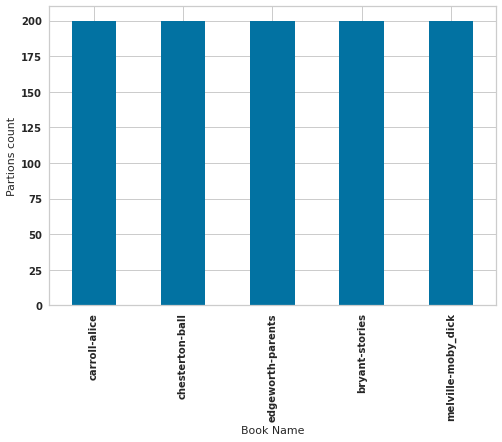

In [12]:
plt.figure(figsize=(12, 8))
fig, ax = plt.subplots()
all_books_df.label.value_counts().plot(ax=ax, kind='bar', xlabel='numbers', ylabel='frequency')
plt.xlabel('Book Name')
plt.ylabel('Partions count')
plt.savefig('partions_counts.png', bbox_inches='tight')

## Clean, Remove stop-words and Steeming

In [13]:
# clean
all_books_df['cleaned_partions'] = all_books_df.partions.apply(clean)

In [14]:
# Remove stop words 
all_stopwords = nlp.Defaults.stop_words
remove_stop_words = lambda x: ' '.join([word for word in word_tokenize(x) if not word in all_stopwords])

all_books_df['partions_without_stop_words'] = all_books_df.partions.apply(remove_stop_words)

In [15]:
# Steem words
all_books_df['steemed_partions'] = all_books_df.partions.apply(processText)

In [16]:
all_books_df.head()

,partions,label,cleaned_partions,partions_without_stop_words,steemed_partions
0,certain it must be really offended we won talk...,carroll-alice,certain it must be really offended we won talk...,certain offended won talk cried mouse tremblin...,certain offend win talk cry mouse tremble end ...
1,the fact keep them to sell the hatter added as...,carroll-alice,the fact keep them to sell the hatter added as...,fact sell hatter added explanation ve m hatter...,fact sell hatter add explanation ve m hatter q...
2,this moment tell you but she went on all the s...,carroll-alice,this moment tell you but she went on all the s...,moment tell went shedding gallons tears large ...,moment tell shed gallon tear large pool round ...
3,of what sort it was scratching and scrambling ...,carroll-alice,of what sort it was scratching and scrambling ...,sort scratching scrambling chimney close sayin...,sort scratch scramble chimney close bill sharp...
4,there seemed to be no chance of this so she be...,carroll-alice,there seemed to be no chance of this so she be...,chance began looking pass away time alice cour...,chance begin look pass away time alice court j...


Text(0, 0.5, '# of partions')

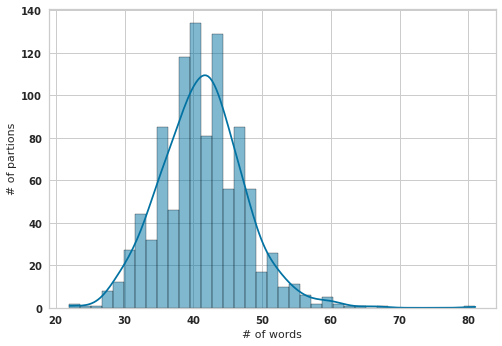

In [17]:
x = all_books_df.steemed_partions.apply(lambda x: len(x.split()))
sns.histplot(data=all_books_df, x=x, kde=True)
plt.xlabel("# of words")
plt.ylabel("# of partions")

Text(0.5, 0, '# of words')

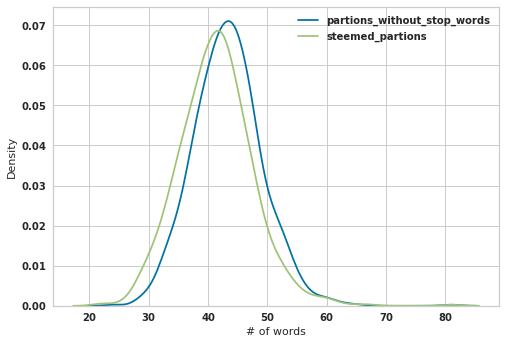

In [18]:
x = all_books_df.partions_without_stop_words.apply(lambda x: len(x.split()))
sns.kdeplot(x, label='partions_without_stop_words')
x = all_books_df.steemed_partions.apply(lambda x: len(x.split()))
sns.kdeplot(x, label='steemed_partions')
plt.legend()
plt.xlabel('# of words')

In [19]:
from collections import Counter
word_cloud = []
df_res = {}
for bn in all_books_df.label.unique():
    book1 = clean(all_books_df.steemed_partions[all_books_df.label == bn].str.cat(sep=" "))
    book1_counter = Counter(clean(book1).split(' '))
    word_cloud.append((bn, {i[0]: i[1] for i in book1_counter.most_common(10)}))
    df_res[bn] = [i[0] for i in book1_counter.most_common(10)]

# Most common words for each book

In [20]:
from wordcloud import WordCloud
import ipywidgets
from IPython.core.pylabtools import figsize

def wordBook (bookList =[] ):
    if len(bookList) > 0 :
        B1 = bookList[0][1]
        drop_Down = ipywidgets.Dropdown(options = bookList  , value = B1 , description= 'book')
        def updateWordCloud (choice):
            wordcloud = WordCloud(colormap="tab20").generate_from_frequencies(choice)
            plt.figure(figsize=(8,8))
            plt.imshow(wordcloud)
            plt.axis('off')
        ipywidgets.interact(updateWordCloud , choice = drop_Down)
    else:
        print('plz send u book list')

In [21]:
wordBook(word_cloud)

interactive(children=(Dropdown(description='book', options=(('carroll-alice', {'alice': 312, 'think': 96, 'lit…

In [22]:
pd.DataFrame(df_res)

,carroll-alice,chesterton-ball,edgeworth-parents,bryant-stories,melville-moby_dick
0,alice,turnbull,come,little,whale
1,think,man,mr,come,man
2,little,macian,know,look,ship
3,look,like,good,king,like
4,like,come,think,man,sea
5,know,look,ll,run,ye
6,come,know,sir,think,ahab
7,begin,think,time,like,old
8,thing,thing,susan,great,white
9,queen,face,little,good,look


# Split data

In [23]:
X_train, X_test, y_train, y_test = train_test_split(all_books_df.steemed_partions,
                                                    all_books_df.label,
                                                    test_size=0.30,
                                                    random_state=42)

# Transformation and Embeding

In [24]:
max_df = 0.7

### 1- BOW

In [25]:
BOW = CountVectorizer()

### 2- TF-IDF

In [26]:
TFIDF = TfidfVectorizer(stop_words='english', max_df=max_df)

### 3-BOW-n-gram

In [27]:
BOW_NGRAM = CountVectorizer(stop_words='english', ngram_range=(2,2), max_df=max_df)

### 4- TF-IDF-n-gram

In [28]:
TFIDF_NGRAM = TfidfVectorizer(stop_words='english', ngram_range=(2,2), max_df=max_df)

### 5- glove

In [29]:
glove = api.load("glove-wiki-gigaword-300")

### 6- word2vec

In [30]:
word2vec = api.load("word2vec-google-news-300")

### 7- FastTxt

In [31]:
fastTxt = api.load("fasttext-wiki-news-subwords-300")

# Check which Dimensionality reduction algorithm works well with which Embedding way.

##### Dimensionality reduction Algorithems that will be check "LDA" & "PCA" & "T-SNE" & "UMAP"

#### BOW

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


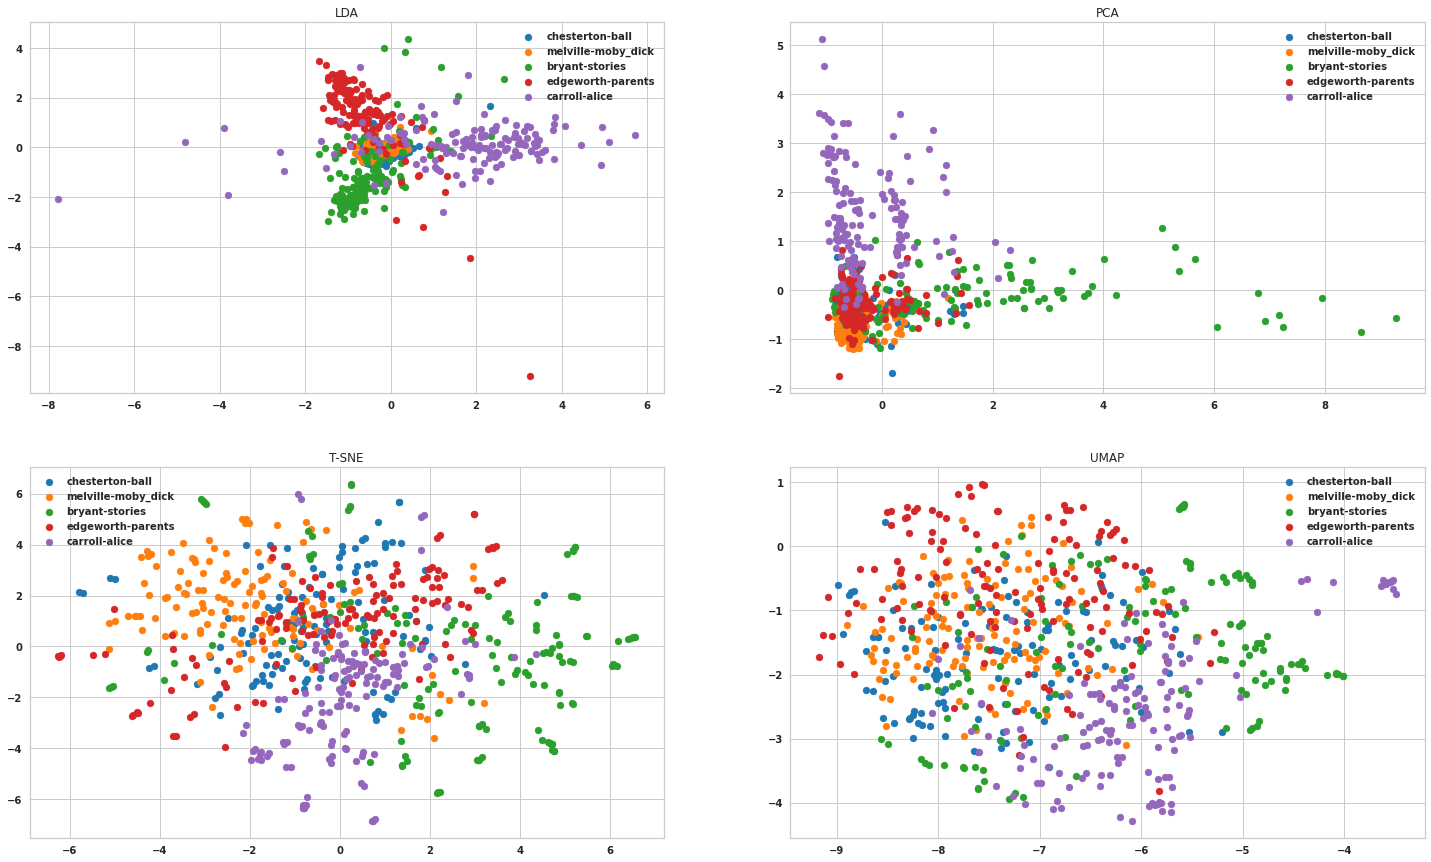

In [35]:
plotPragraphSpace(X_train, y_train, BOW)

#### TFIDF

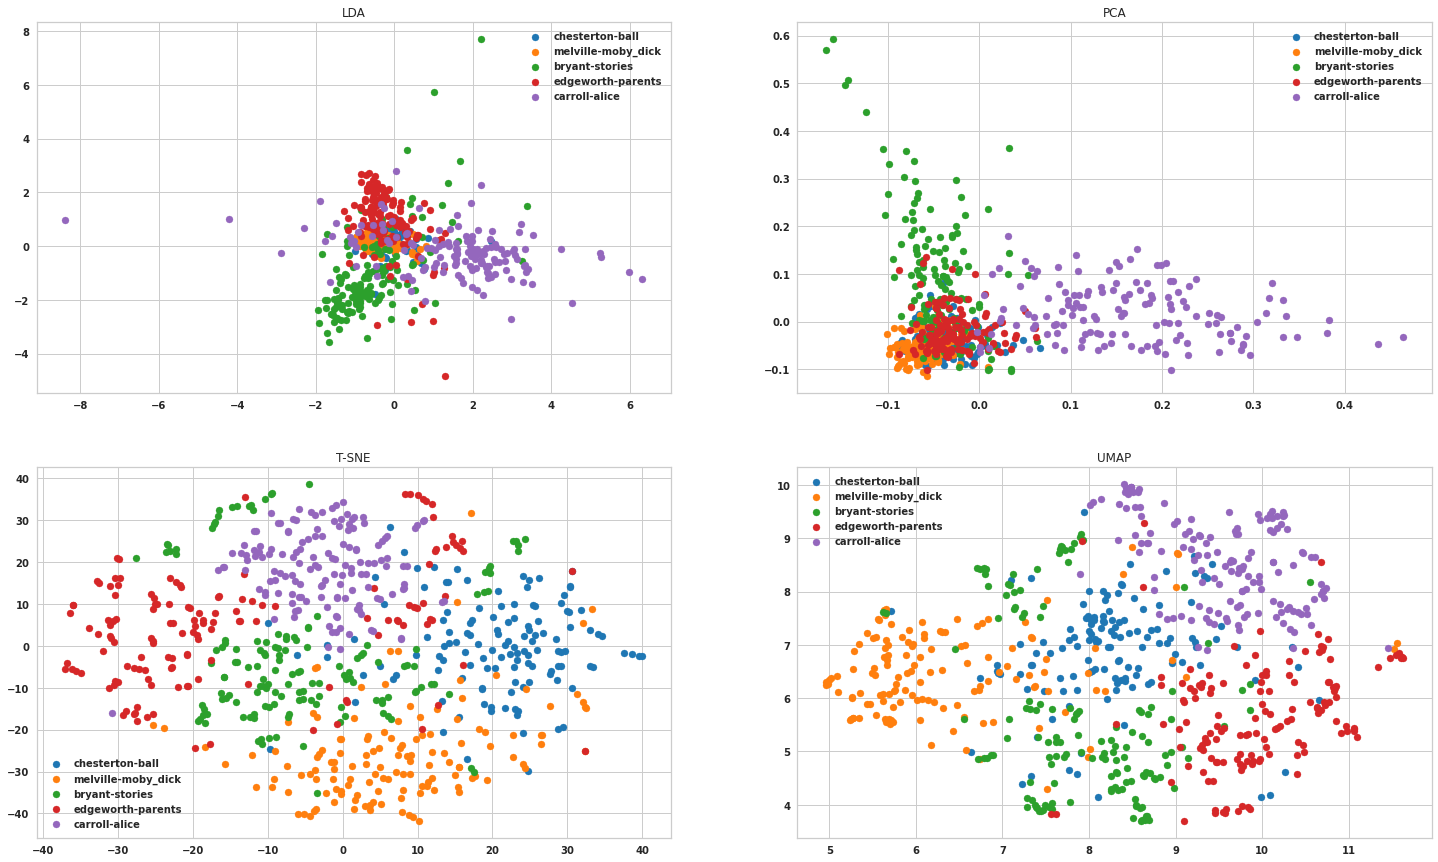

In [36]:
plotPragraphSpace(X_train, y_train, TFIDF)

#### BOW-n-gram

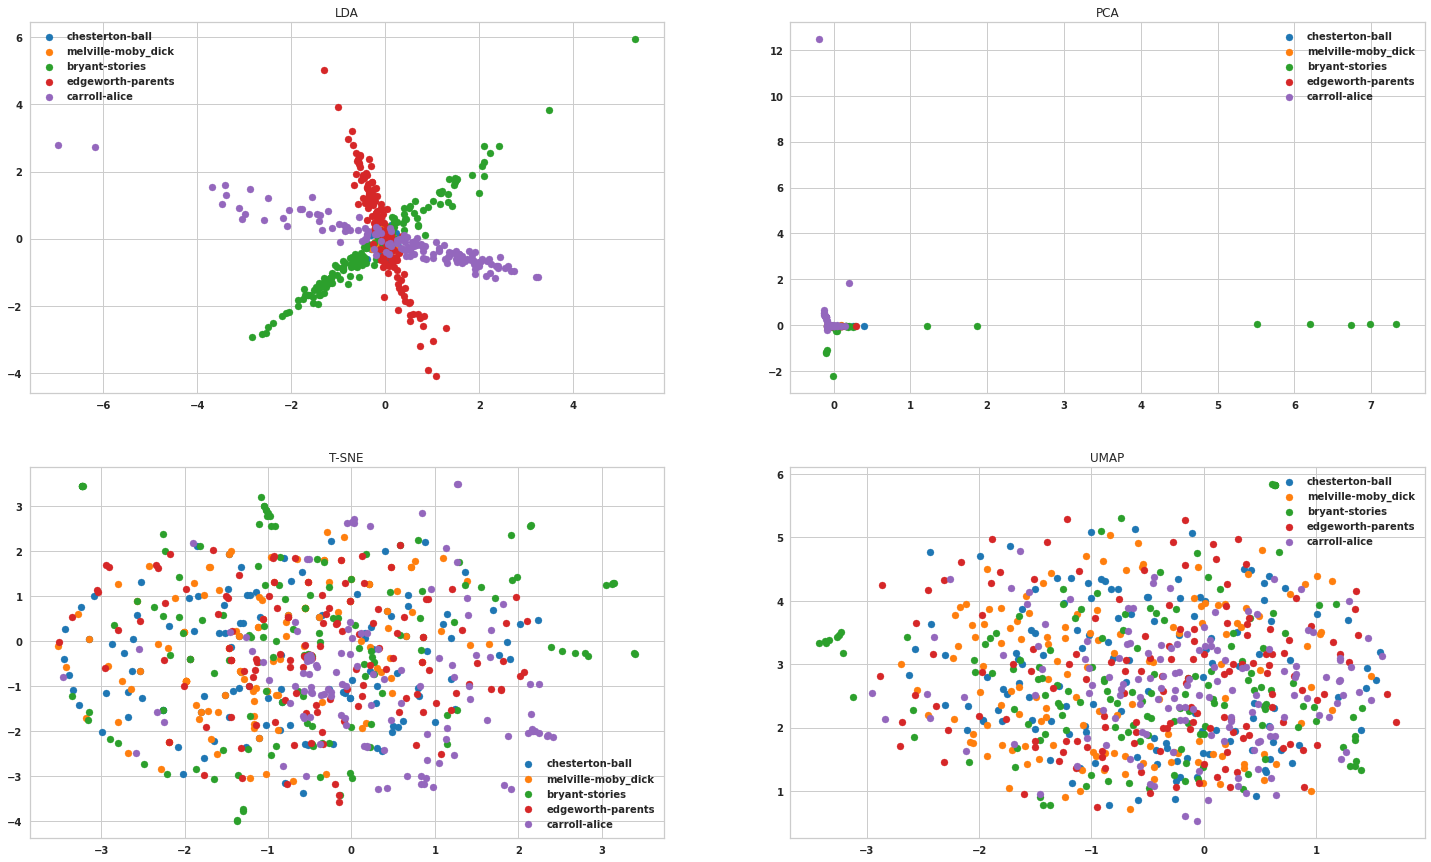

In [37]:
plotPragraphSpace(X_train, y_train, BOW_NGRAM)

#### TFIDF-n-gram

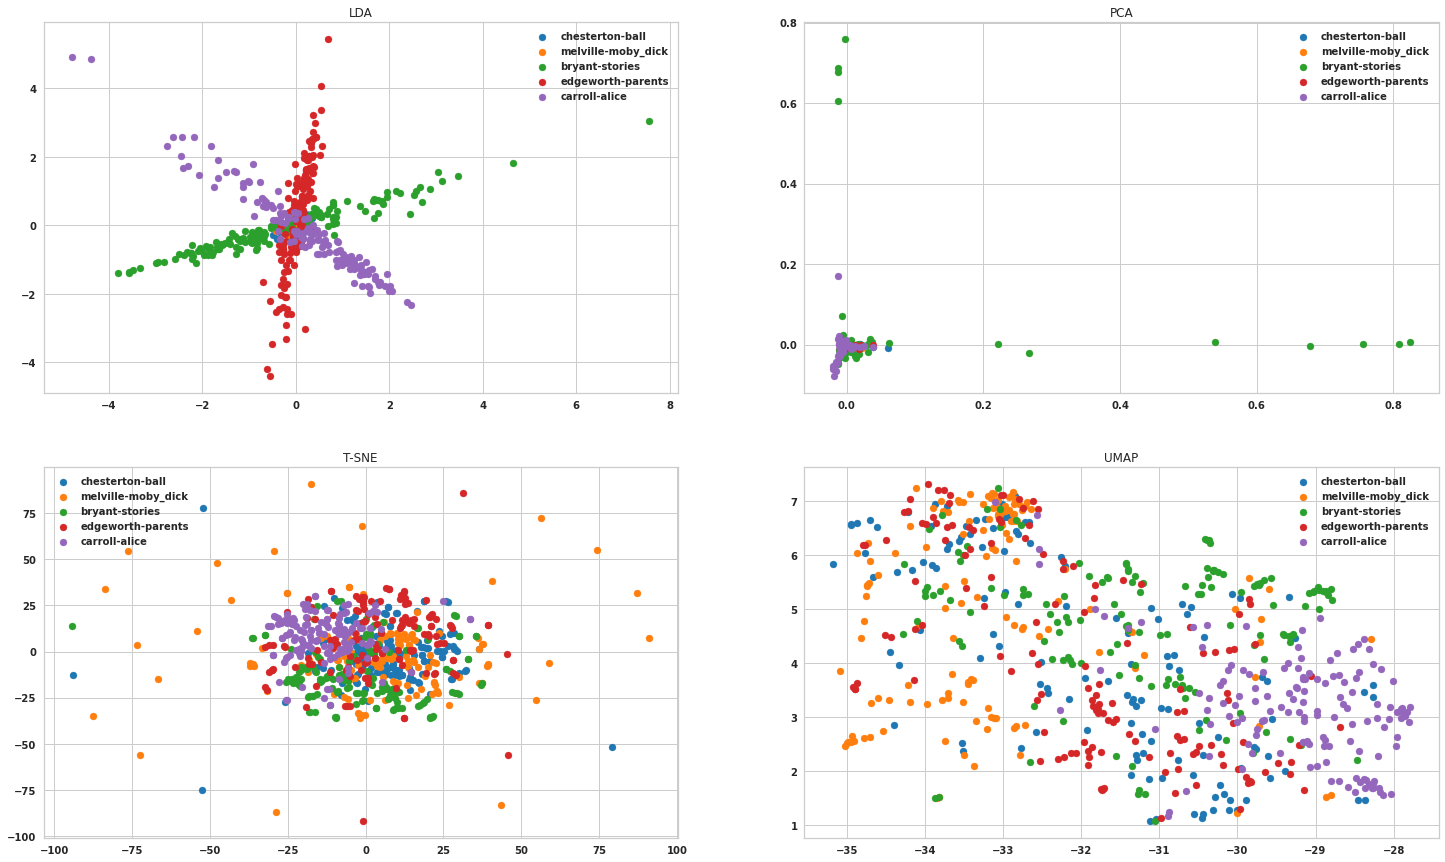

In [38]:
plotPragraphSpace(X_train, y_train, TFIDF_NGRAM)

#### Glove

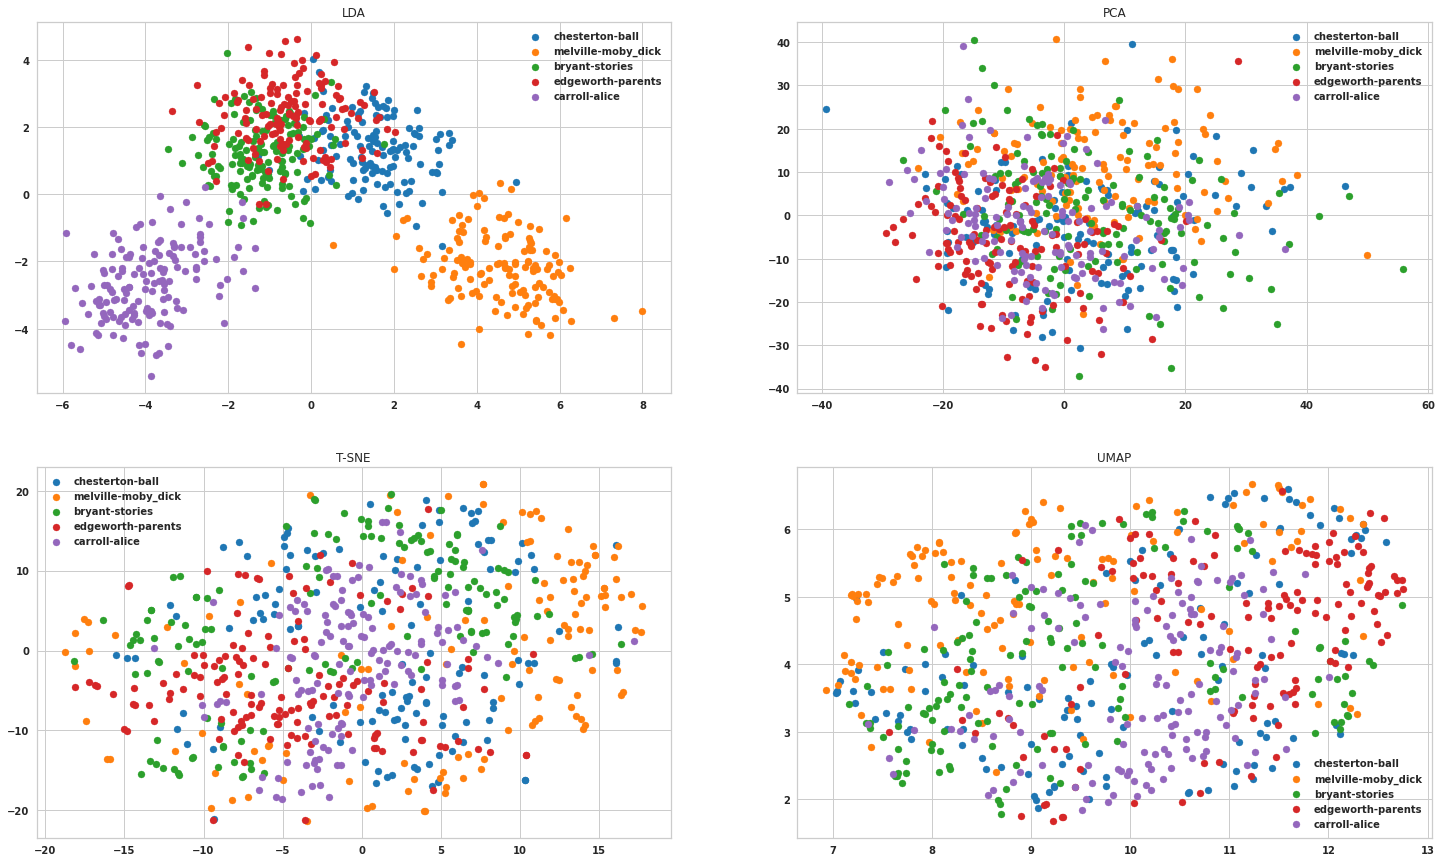

In [39]:
plotPragraphSpace(X_train, y_train, glove, custom=True)

#### Word2Vec

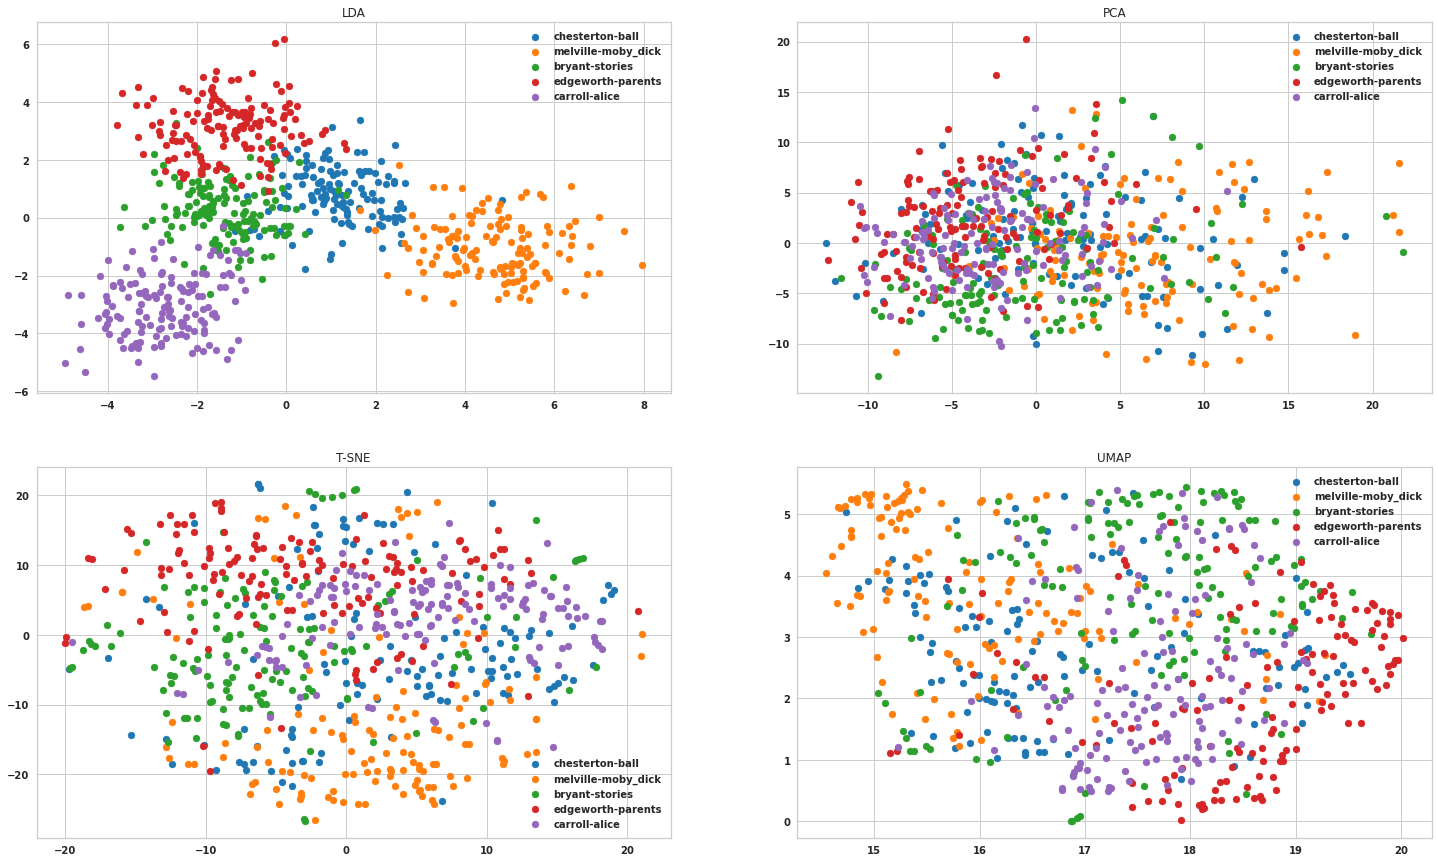

In [40]:
plotPragraphSpace(X_train, y_train, word2vec, custom=True)

#### FastTxt

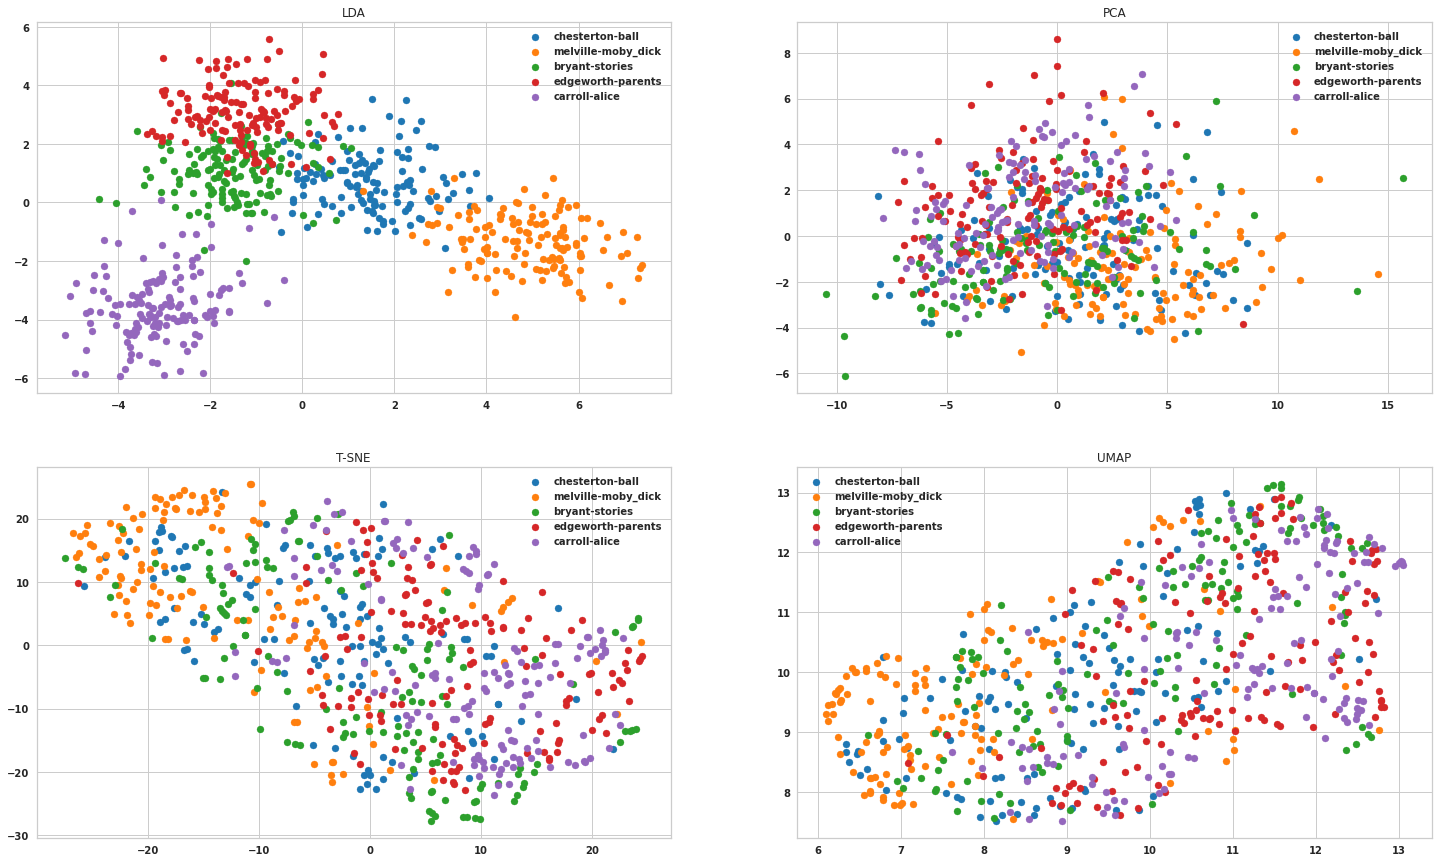

In [41]:
plotPragraphSpace(X_train, y_train, fastTxt, custom=True)

# Modeling

In [45]:
# SVM
parameters = {'kernel': ["poly"],#('linear', 'rbf', 'poly'),
              'C': [50],#np.arange(1, 50, 10),
              'degree': [2],#,3,4],             
             }
svc = SVC(random_state=42, decision_function_shape='ovo', probability=True)

# NB
nb_model = MultinomialNB()

# DT
dt_model = DecisionTreeClassifier(min_samples_split=30,
                                  min_samples_leaf=10)

# RF
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=30, min_samples_leaf=10)

# KNN
knn_model = KNeighborsClassifier()

# DeepNN
dnn_model = MLPClassifier(hidden_layer_sizes=(7,5),
                            activation='tanh',
                            random_state=42,
                            solver='sgd',
                            max_iter=2000,
                            learning_rate='adaptive')

# LDA-classifier
lda_model = LinearDiscriminantAnalysis()


# Bert
# RL

dim_reduct = LinearDiscriminantAnalysis(n_components=2)

models = {
    "svm-bow": (svc, parameters, BOW, dim_reduct),
    "svm-tfidf": (svc, parameters, TFIDF, dim_reduct),
    "svm-bow-n-gram": (svc, parameters, BOW_NGRAM, dim_reduct),
    "svm-tfidf-n-gram": (svc, parameters, TFIDF_NGRAM, dim_reduct),
    "svm-fastTxt": (svc, parameters, CustomVectorizer(model=fastTxt), dim_reduct),
    
    "nb_model-bow": (nb_model, {}, BOW, dim_reduct),
    "nb_model-tfidf": (nb_model, {}, TFIDF, dim_reduct),
    "nb_model-bow-n-gram": (nb_model, {}, BOW_NGRAM, dim_reduct),
    "nb_model-tfidf-n-gram": (nb_model, {}, TFIDF_NGRAM, dim_reduct),
    "nb_model-fastTxt": (nb_model, {}, CustomVectorizer(model=fastTxt), dim_reduct),
    
    "dt_model-bow": (dt_model, {}, BOW, dim_reduct),
    "dt_model-tfidf": (dt_model, {}, TFIDF, dim_reduct),
    "dt_model-bow-n-gram": (dt_model, {}, BOW_NGRAM, dim_reduct),
    "dt_model-tfidf-n-gram": (dt_model, {}, TFIDF_NGRAM, dim_reduct),
    "dt_model-fastTxt": (dt_model, {}, CustomVectorizer(model=fastTxt), dim_reduct),
    
    "rf_model-bow": (rf_model, {}, BOW, dim_reduct),
    "rf_model-tfidf": (rf_model, {}, TFIDF, dim_reduct),
    "rf_model-bow-n-gram": (rf_model, {}, BOW_NGRAM, dim_reduct),
    "rf_model-tfidf-n-gram": (rf_model, {}, TFIDF_NGRAM, dim_reduct),
    "rf_model-fastTxt": (rf_model, {}, CustomVectorizer(model=fastTxt), dim_reduct),
    
    "knn_model-bow": (knn_model, {}, BOW, dim_reduct),
    "knn_model-tfidf": (knn_model, {}, TFIDF, dim_reduct),
    "knn_model-bow-n-gram": (knn_model, {}, BOW_NGRAM, dim_reduct),
    "knn_model-tfidf-n-gram": (knn_model, {}, TFIDF_NGRAM, dim_reduct),
    "knn_model-fastTxt": (knn_model, {}, CustomVectorizer(model=fastTxt), dim_reduct),
    
    "dnn_model-bow": (dnn_model, {}, BOW, dim_reduct),
    "dnn_model-tfidf": (dnn_model, {}, TFIDF, dim_reduct),
    "dnn_model-bow-n-gram": (dnn_model, {}, BOW_NGRAM, dim_reduct),
    "dnn_model-tfidf-n-gram": (dnn_model, {}, TFIDF_NGRAM, dim_reduct),
    "dnn_model-fastTxt": (dnn_model, {}, CustomVectorizer(model=fastTxt), dim_reduct),
    
    "lda_model-bow": (lda_model, {}, BOW, dim_reduct),
    "lda_model-tfidf": (lda_model, {}, TFIDF, dim_reduct),
    "lda_model-bow-n-gram": (lda_model, {}, BOW_NGRAM, dim_reduct),
    "lda_model-tfidf-n-gram": (lda_model, {}, TFIDF_NGRAM, dim_reduct),
    "lda_model-fastTxt": (lda_model, {}, CustomVectorizer(model=fastTxt), dim_reduct),
}

model_results = {}

In [46]:
for key, model_tuple in models.items():
    print(f"start :: {key}")
    results = {}
    
    model, loc_paramaters, vectorizer, dim_redu_algo = model_tuple

    model_Grid = GridSearchCV(model, loc_paramaters)
    
    model_pipline = Pipeline([
        ('vect', vectorizer),
        ('to_dense', DenseTransformer()),
        ('dimen_red',  dim_redu_algo),
        ('scaller', MinMaxScaler()),
        ('clf', model_Grid),
    ])
    
    # train model
    model_pipline.fit(X_train, y_train)
    
    best_model = model_pipline['clf'].best_estimator_
    results['best_paramaters'] = model_pipline['clf'].best_params_
    
    eval_pipline = Pipeline([
        ('vect', vectorizer),
        ('to_dense', DenseTransformer()),
        ('dimen_red',  LinearDiscriminantAnalysis(n_components=2)),
        ('scaller', MinMaxScaler()),
        ('clf', best_model),
    ])
    eval_pipline.fit(X_train, y_train)
    results['best_model'] = eval_pipline
    results['train_accuracy'] = eval_pipline.score(X_train, y_train)
    
    # evaluate model train-set (cross-validation)
    scores = cross_val_score(eval_pipline, X_train, y_train, cv=10, scoring='f1_macro')
    results['cross_val_scores'] = scores
    results['avg_f1_score_cross_validation_trainset'] = scores.mean()
    
    model_results[key] = results
    
    print(f"end :: {key} - {round(scores.mean(), 2)} - {round(results['train_accuracy'], 2)}")
    print("-"*20)

start :: svm-bow
end :: svm-bow - 0.45 - 0.67
--------------------
start :: svm-tfidf
end :: svm-tfidf - 0.42 - 0.69
--------------------
start :: svm-bow-n-gram
end :: svm-bow-n-gram - 0.07 - 0.51
--------------------
start :: svm-tfidf-n-gram
end :: svm-tfidf-n-gram - 0.12 - 0.49
--------------------
start :: svm-fastTxt
end :: svm-fastTxt - 0.62 - 0.9
--------------------
start :: nb_model-bow
end :: nb_model-bow - 0.11 - 0.25
--------------------
start :: nb_model-tfidf
end :: nb_model-tfidf - 0.11 - 0.28
--------------------
start :: nb_model-bow-n-gram
end :: nb_model-bow-n-gram - 0.07 - 0.21
--------------------
start :: nb_model-tfidf-n-gram
end :: nb_model-tfidf-n-gram - 0.07 - 0.25
--------------------
start :: nb_model-fastTxt
end :: nb_model-fastTxt - 0.3 - 0.45
--------------------
start :: dt_model-bow
end :: dt_model-bow - 0.42 - 0.75
--------------------
start :: dt_model-tfidf
end :: dt_model-tfidf - 0.4 - 0.74
--------------------
start :: dt_model-bow-n-gram
end :: d

In [85]:
# model_obj = model_results['svm-bow']
# labels = model_obj['best_model']['clf'].classes_
# getModelReport(model_obj['best_model'], X_test, y_test, labels=labels)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


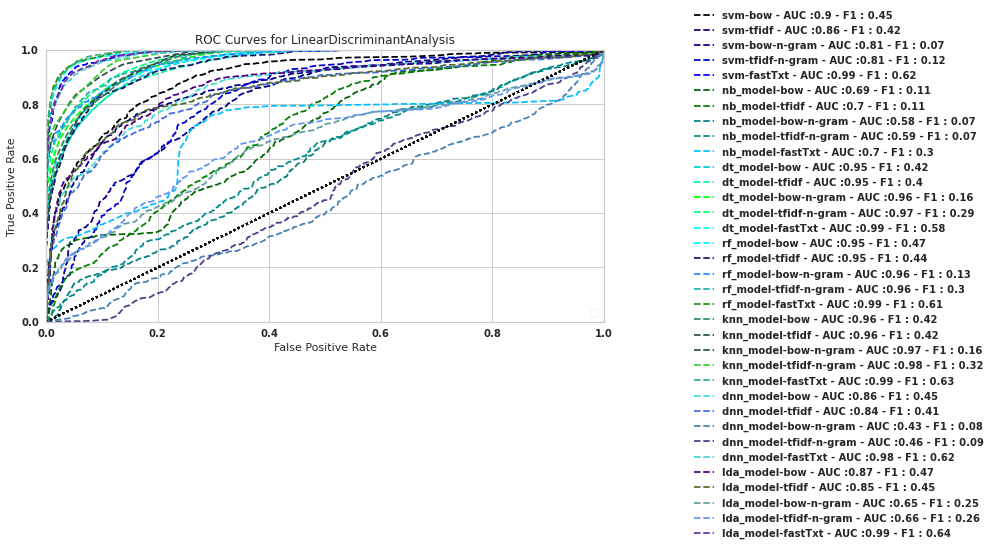

In [86]:
fig, ax = plt.subplots(figsize=(10,5))
colors =  sorted(list(mcolors.CSS4_COLORS.values()))
for i, model_name in enumerate(list(model_results.keys())):
    model_obj = model_results[model_name]
    labels = model_obj['best_model']['clf'].classes_
    
    visualizer = ROCAUC(model_obj['best_model'], micro=False,  per_class=False, ax=ax, classes=labels )
    visualizer.fit(X_train, y_train)        
    visualizer.score(X_train, y_train) 
    
    auc = visualizer.roc_auc['macro']
    ax.get_lines()[(i*2)].set_label(f"{model_name} - AUC :{round(auc,2)} - F1 : {round(model_obj['avg_f1_score_cross_validation_trainset'], 2)}")
    ax.get_lines()[(i*2)].set_color(colors[i])

visualizer.ax.figure.legend(
    bbox_to_anchor=(1.02, 1), 
    borderaxespad=0.0,
    loc='upper left',
)
for i in range(len(ax.get_lines())):
    ax.get_lines()[i].set_label('')

aa = visualizer.show()

In [92]:
visualizer.ax.figure.savefig('Model_Comparizon_ROC.png', bbox_inches='tight')

In [ ]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 17}
plt.rc('font', **font)


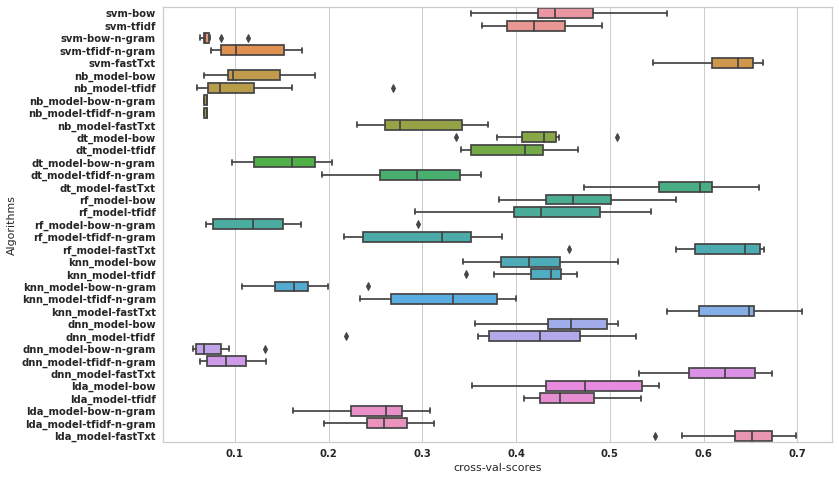

In [94]:
plt.figure(figsize=(12, 8))
results = [model_results[m]['cross_val_scores'] for m in model_results.keys()]
x = np.array(results).ravel()
y = np.array([[i]*10 for i in model_results.keys()]).ravel()
sns.boxplot(x, y)
plt.xlabel('cross-val-scores')
plt.ylabel('Algorithms')
plt.savefig('boxblot-for-cross-val.png', bbox_inches='tight')

In [97]:
x = np.array([[k, k] for k in model_results.keys()]).ravel()
hue = ["train-score", "f1-corss-val-score"] * len(model_results.values())
y = np.array([[m['train_accuracy']*100, m['avg_f1_score_cross_validation_trainset']*100] for m in model_results.values()]).ravel()

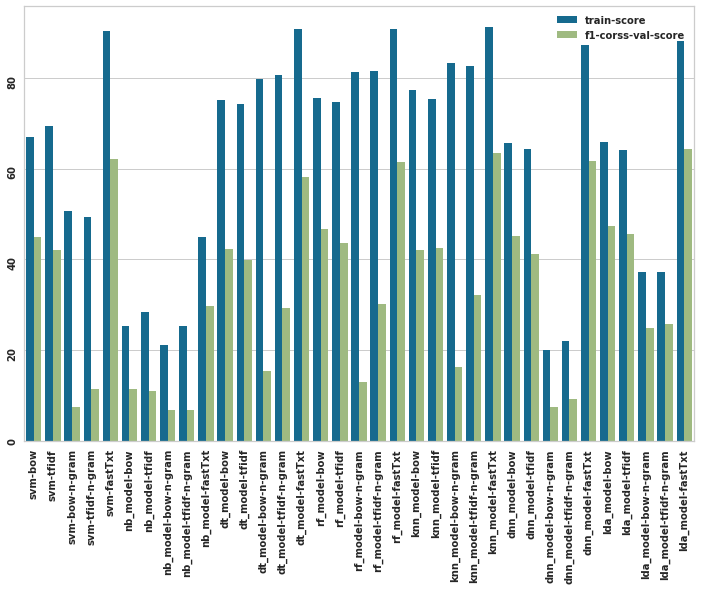

In [100]:
plt.figure(figsize=(12, 8))
sns.barplot(x=x, y=y, hue=hue)
plt.tick_params(axis='x', rotation=90)
plt.tick_params(axis='y', rotation=90)
plt.savefig('barplot_for_accs.png', bbox_inches='tight')

In [51]:
diff_list = [(k, abs(m['train_accuracy']-m['avg_f1_score_cross_validation_trainset']),
              round(m['avg_f1_score_cross_validation_trainset'],2), round(m['train_accuracy'],2))
             for k,m in model_results.items()]

In [53]:
# sorted(diff_list, key=lambda x: x[1])
sorted(diff_list, key=lambda x: x[2], reverse=True)

[('lda_model-fastTxt', 0.23766986481111463, 0.64, 0.88),
 ('knn_model-fastTxt', 0.27717970084047705, 0.63, 0.91),
 ('svm-fastTxt', 0.2808290607955356, 0.62, 0.9),
 ('dnn_model-fastTxt', 0.2569225036669027, 0.62, 0.87),
 ('rf_model-fastTxt', 0.29230374077856514, 0.61, 0.91),
 ('dt_model-fastTxt', 0.326034074248563, 0.58, 0.91),
 ('rf_model-bow', 0.288300040697556, 0.47, 0.76),
 ('lda_model-bow', 0.18587509443597072, 0.47, 0.66),
 ('svm-bow', 0.21891590418478313, 0.45, 0.67),
 ('dnn_model-bow', 0.20467798574276275, 0.45, 0.66),
 ('lda_model-tfidf', 0.1866098436161871, 0.45, 0.64),
 ('rf_model-tfidf', 0.3105036940875928, 0.44, 0.75),
 ('svm-tfidf', 0.2712831806046523, 0.42, 0.69),
 ('dt_model-bow', 0.32754792413253, 0.42, 0.75),
 ('knn_model-bow', 0.35322075315195967, 0.42, 0.77),
 ('knn_model-tfidf', 0.3280281754393035, 0.42, 0.75),
 ('dnn_model-tfidf', 0.23181994977630327, 0.41, 0.64),
 ('dt_model-tfidf', 0.34276685200841395, 0.4, 0.74),
 ('knn_model-tfidf-n-gram', 0.5045633379115222, 0

### Champion model is 'lda_model-fastTxt' which used fastTxt Embedding with LDA dimensionality reduction then applied LDA Classifier

### and for tuning your model, we will increase the number of dimensions in LDA dimensionality reduction, in addition to tune the hyper paramaters of the classifier itself

In [113]:
champion_obj = model_results['lda_model-fastTxt']

In [114]:
champion_model = champion_obj['best_model']

In [144]:
dims = [1, 2, 3, 4]
chanpion_results = {}
for i in dims :
    # LDA
    parameters = {'solver': ('svd', 'lsqr', 'eigen'),
                  'shrinkage': [None, 'Auto'],
                 }

    model_Grid = GridSearchCV(LinearDiscriminantAnalysis(), parameters, cv=10, scoring="f1_macro")

    model_pipline = Pipeline([
        ('vect', CustomVectorizer(model=fastTxt)),
        ('to_dense', DenseTransformer()),
        ('dimen_red',  LinearDiscriminantAnalysis(n_components=i)),
        ('scaller', MinMaxScaler()),
        ('clf', model_Grid),
    ])
    print(i)
    model_pipline.fit(X_train, y_train)
    
    gr = model_pipline['clf']
    
    train_accuracy = model_pipline.score(X_train, y_train)
    
    
    eval_pipline = Pipeline([
        ('vect', CustomVectorizer(model=fastTxt)),
        ('to_dense', DenseTransformer()),
        ('dimen_red',  LinearDiscriminantAnalysis(n_components=i)),
        ('scaller', MinMaxScaler()),
        ('clf', gr.best_estimator_),
    ])
    
    # evaluate model train-set (cross-validation)
    scores = cross_val_score(eval_pipline, X_train, y_train, cv=10, scoring='f1_macro')
    cross_val_scores = scores
    avg_f1_score_cross_validation_trainset = scores.mean()
    
    
    chanpion_results[i] = {
                           "best_model": eval_pipline,
                           "best_paramaters": gr.best_params_,
                           "train_accuracy": train_accuracy,
                           "cross_val_scores": cross_val_scores,
                           "avg_f1_score_cross_validation_trainset": avg_f1_score_cross_validation_trainset,
                          }
    

1
2
3
4


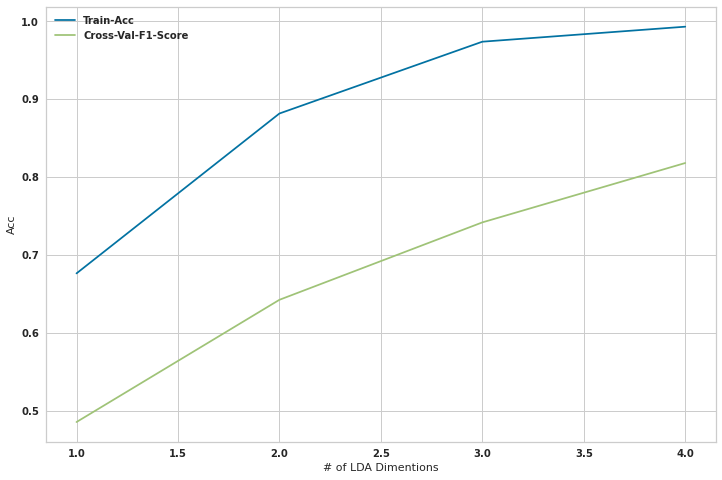

In [145]:
plt.figure(figsize=(12, 8))
plt.plot(list(chanpion_results.keys()), [chanpion_results[k]['train_accuracy'] for k in chanpion_results.keys()], label= "Train-Acc")
plt.plot(list(chanpion_results.keys()), [chanpion_results[k]['avg_f1_score_cross_validation_trainset'] for k in chanpion_results.keys()], label= "Cross-Val-F1-Score")
plt.legend()
plt.xlabel('# of LDA Dimentions')
plt.ylabel('Acc')
plt.savefig('chanpion_acc_plot.png', bbox_inches='tight')

In [162]:
chanpion_results[3]

{'best_model': Pipeline(steps=[('vect',
                  CustomVectorizer(model=<gensim.models.keyedvectors.KeyedVectors object at 0x28e94b550>)),
                 ('to_dense', <__main__.DenseTransformer object at 0x427927fd0>),
                 ('dimen_red', LinearDiscriminantAnalysis(n_components=3)),
                 ('scaller', MinMaxScaler()),
                 ('clf', LinearDiscriminantAnalysis())]),
 'best_paramaters': {'shrinkage': None, 'solver': 'svd'},
 'train_accuracy': 0.9737149661223483,
 'cross_val_scores': array([0.77951702, 0.80044356, 0.69969892, 0.69655616, 0.7226268 ,
        0.75422179, 0.83624501, 0.69901001, 0.67162951, 0.75726403]),
 'avg_f1_score_cross_validation_trainset': 0.7417212807853859}

model : 
acc :: 0.9728571428571429
                    precision    recall  f1-score   support

    bryant-stories       0.94      0.95      0.94       147
     carroll-alice       1.00      0.98      0.99       145
   chesterton-ball       0.99      0.99      0.99       129
 edgeworth-parents       0.94      0.96      0.95       143
melville-moby_dick       1.00      0.99      1.00       136

          accuracy                           0.97       700
         macro avg       0.97      0.97      0.97       700
      weighted avg       0.97      0.97      0.97       700



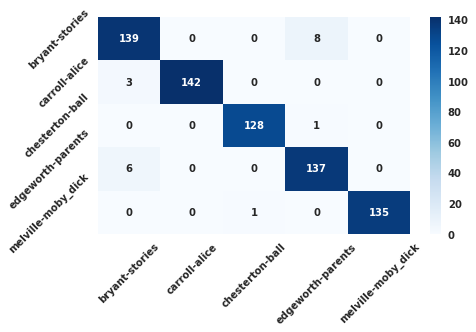

Error Analysis


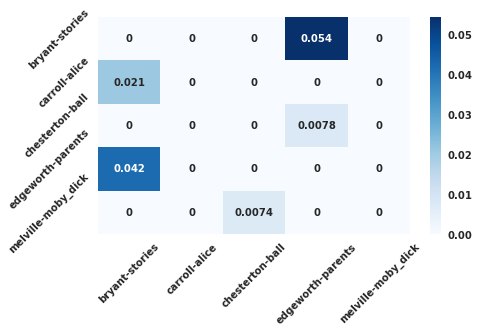

In [159]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}
plt.rc('font', **font)


best_one = chanpion_results[3]['best_model'].fit(X_train, y_train)
getModelReport(best_one, X_train, y_train, best_model.classes_)

model : 
acc :: 0.8
                    precision    recall  f1-score   support

    bryant-stories       0.67      0.74      0.70        53
     carroll-alice       0.89      0.87      0.88        55
   chesterton-ball       0.83      0.80      0.81        71
 edgeworth-parents       0.74      0.74      0.74        57
melville-moby_dick       0.87      0.84      0.86        64

          accuracy                           0.80       300
         macro avg       0.80      0.80      0.80       300
      weighted avg       0.80      0.80      0.80       300



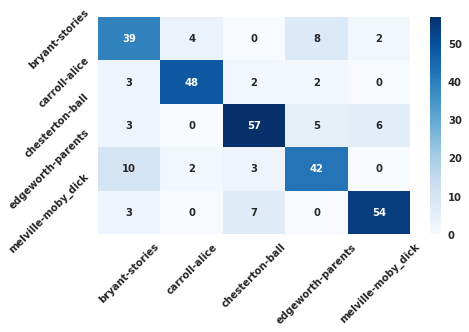

Error Analysis


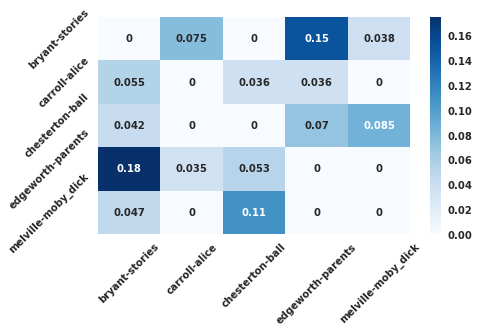

In [160]:
getModelReport(best_one, X_test, y_test, best_model.classes_)

In [161]:
# # # pipline
# 1- "read_data" 
# 2- "clean special character" 
# 3- "remove stop-words"
# 4- "steeming" 
# 5- "split data to train and test" 
# 6- "Transform (Embedding)"
# 7- "Select best dimentinality reduction with best Embedding Visually" 
# 8- "Modeling"
# 9- "Choose Chamboion model"
# 10- "tuen champion model"
# 11- "Evaluation On Test"